In [ ]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
device = torch.device('cuda:0')

from tqdm import tqdm
from PIL import Image
from skimage import color

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error


In [ ]:
image_size = 256 # for cropping (image_size x image_size) square from center
class IDAO_data(Dataset):
    def __init__(self, path, transforms_img, is_train=True):
        self.is_train = is_train
        self.transforms_img = transforms_img
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.png') or file.endswith('.PNG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        self.paths = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
                    self.paths.append(filename)
            except:
                print('Could not load image:', filename)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        return self.transforms_img(img).view(1, image_size, image_size), idx
    
    def get_image(self, idx):
        return self.images[idx]

    def get_filename(self, idx):
        return self.paths[idx]

In [ ]:
transforms_all = transforms.Compose([
    transforms.CenterCrop((image_size, image_size)),
    # transforms.ColorJitter(contrast=[2.5, 2.5]),
    transforms.ColorJitter(contrast=[3.0, 3.0]), # can change contrast
    transforms.ToTensor(),
])

dataset = IDAO_data('idao_dataset\\train', transforms_all)
loader = DataLoader(dataset, batch_size=8, shuffle=True) # can change batch_size : 8, 16, 32, 64 <-- more == better

100%|███████████████████████████████████████████████████████████████████████████| 13408/13408 [00:36<00:00, 367.75it/s]


## Autoencoder Model

In [ ]:
class Autoencoder_model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(), 
            nn.Conv2d(64, 64, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(), 
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.Conv2d(64, 128, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(),
            nn.AvgPool2d((2, 2), stride=(2, 2)),
            nn.Conv2d(128, 128, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, (5, 5), padding=2, padding_mode='reflect'), 
            nn.SiLU(),
            nn.Conv2d(256, 256, (5, 5), padding=2, padding_mode='reflect'), 
            nn.SiLU(),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.Conv2d(256, 256, (5, 5), padding=2, padding_mode='reflect'), 
            nn.SiLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, (5, 5), padding=2, padding_mode='reflect'), 
            nn.SiLU(),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.Conv2d(256, 256, (3, 3), padding=1, padding_mode='reflect'), 
            nn.SiLU(),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.Conv2d(256, 256, (3, 3), padding=1, padding_mode='reflect'), 
            nn.SiLU(),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
        )
         
        self.decoder = nn.Sequential(         
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(256, 128, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 128, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 128, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            # nn.Conv2d(128, 128, (3, 3), padding=1, padding_mode='reflect'),
            # nn.SiLU(),
            nn.Conv2d(128, 128, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 128, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(),
            nn.Conv2d(64, 32, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(),
            nn.Conv2d(32, 1, (3, 3), padding=1, padding_mode='reflect'),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        h = self.encoder(x)
        # h = torch.cat((h, x), 1)
        h = self.decoder(h)
        return h

In [ ]:
def predict_PIL(model_, idx):
    X_test = dataset[idx][0]
    y_test = model_(X_test.view(1, 1, image_size, image_size).cuda())
    y_test = y_test.detach().cpu()
    return transforms.ToPILImage()(y_test.view(image_size, image_size))

## Train model

In [ ]:
model = Autoencoder_model().cuda()

In [ ]:
def train_model(epochs=3, lr=0.0001, verbose=True):
    # Here we train our Autoencoder
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # can change lr for better score - learning rate in gradient descent. Maybe can change optimizer, but Adam is good
    criterion = nn.MSELoss() # can change loss criterion
    if verbose:
        print('Training model...',
              'Optimizer: ' + str(optimizer), 
              'Criterion: ' + str(criterion),
              'epochs: ' + str(epochs),
              sep='\n'
              )

    for epoch in range(epochs): # can change number of epochs - the more the better. But one epoch = ~10 minutes
        losses = []
        for X, y in loader:
            optimizer.zero_grad()
            y_pred = model(X.cuda())
            loss = criterion(y_pred, X.cuda())
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
        print('epoch:', epoch, '\n mean_loss:', np.mean(losses))
        plt.plot(losses)
        plt.show()
        display(predict_PIL(model, 9))
    
    if verbose:
        print('Training finished')

Training model...
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 6e-05
    weight_decay: 0
)
Criterion: MSELoss()
epochs: 5
epoch: 0 
 mean_loss: 0.0017609722420672146


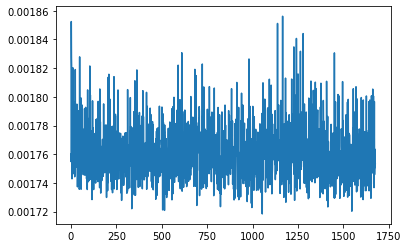

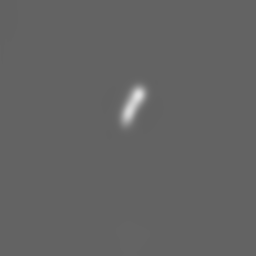

epoch: 1 
 mean_loss: 0.0017586902889333053


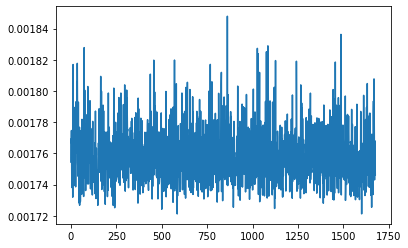

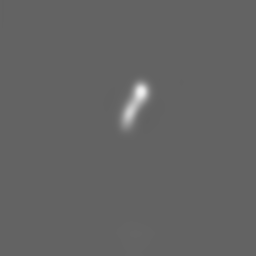

epoch: 2 
 mean_loss: 0.0017566891846375935


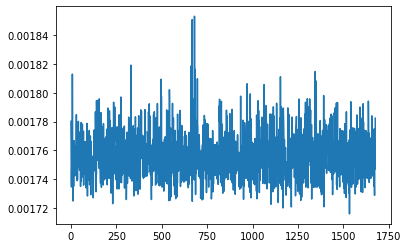

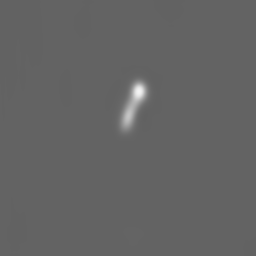

epoch: 3 
 mean_loss: 0.0017562356834029801


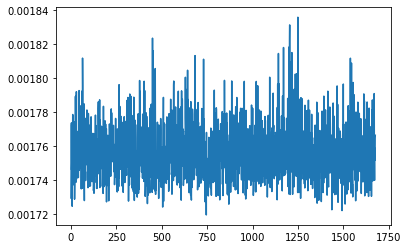

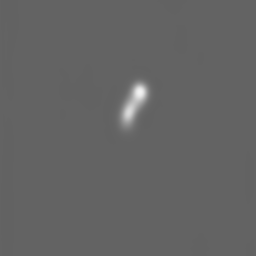

epoch: 4 
 mean_loss: 0.0017543646789251477


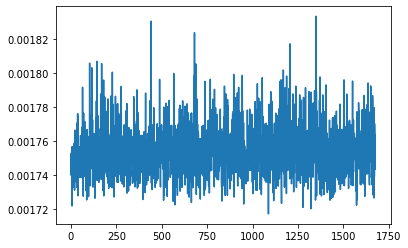

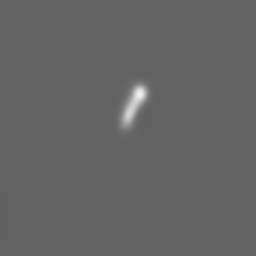

Training finished
Training model...
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 2e-05
    weight_decay: 0
)
Criterion: MSELoss()
epochs: 4
epoch: 0 
 mean_loss: 0.0017489049980846992


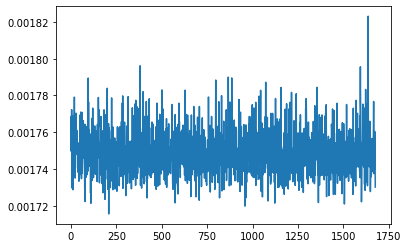

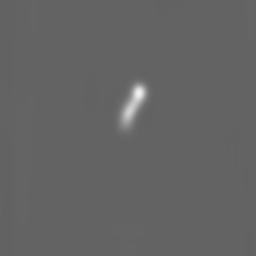

epoch: 1 
 mean_loss: 0.0017477963589990916


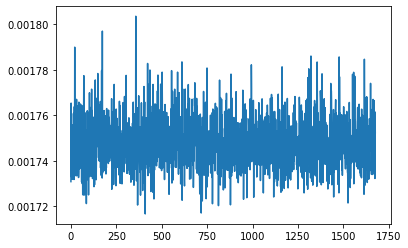

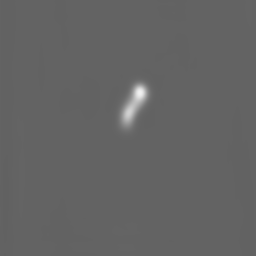

epoch: 2 
 mean_loss: 0.0017472207413565118


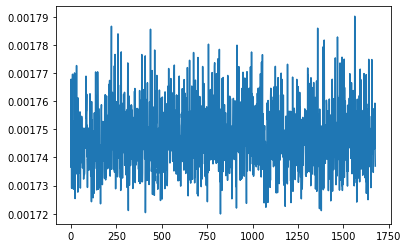

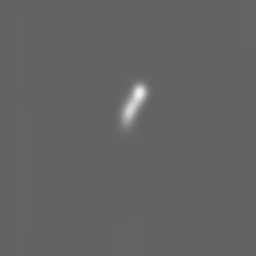

epoch: 3 
 mean_loss: 0.0017469537803938785


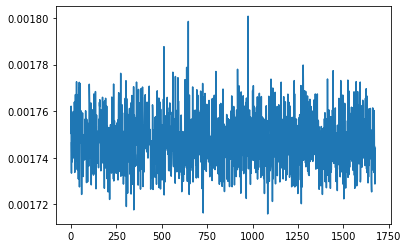

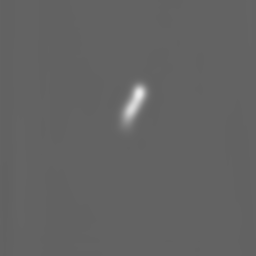

Training finished


In [ ]:
train_model(5, 0.00006)
train_model(4, 0.00002)

Training model...
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 8e-05
    weight_decay: 0
)
Criterion: MSELoss()
epochs: 1
epoch: 0 
 mean_loss: 0.0017673791473568029


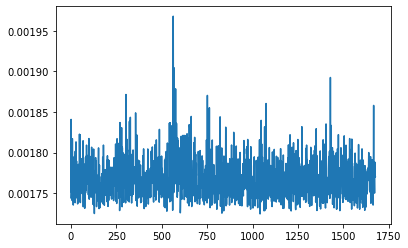

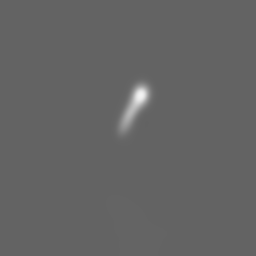

Training finished


In [ ]:
train_model(epochs=1, lr=0.00008)

Посмотрим на то, как наша модель сохраняет картиночки

To-do: попробовать другие преобразования -- сейчас модель очень слабо восстанавливает картинку

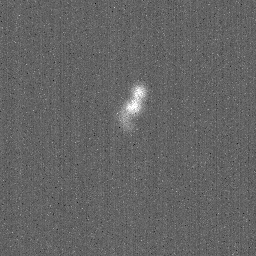

In [ ]:
transforms.ColorJitter(contrast=[3.0, 3.0])(transforms.CenterCrop((256, 256))(dataset.get_image(9))) # ER 30 kev
# original:

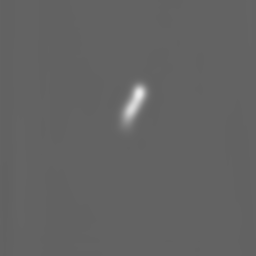

In [ ]:
predict_PIL(model, 9)
# after encoding-decoding

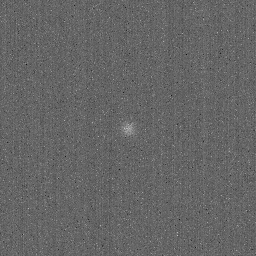

In [ ]:
transforms.ColorJitter(contrast=[3.0, 3.0])(transforms.CenterCrop((256, 256))(dataset.get_image(10))) # ER 3 kev
# original:

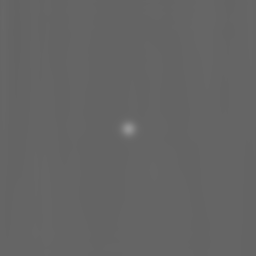

In [ ]:
predict_PIL(model, 10)
# after encoding-decoding

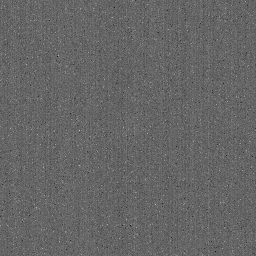

In [ ]:
transforms.ColorJitter(contrast=[3.0, 3.0])(transforms.CenterCrop((256, 256))(dataset.get_image(10000))) # HR 1 kev
# original:

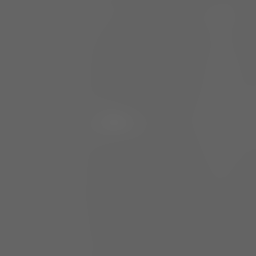

In [ ]:
predict_PIL(model, 10000)

## Loading model

In [ ]:
torch.save(model.state_dict(), 'C:\\Users\\Timofey\\Autoencoder_idao_3.pth') # <-- save model

In [ ]:
# load model
model_new = Autoencoder_model().cuda()
model_new.load_state_dict(torch.load('C:\\Users\\Timofey\\Autoencoder_idao_1.pth'))
model_new.eval()

Autoencoder_model(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): SiLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (3): SiLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (6): SiLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (8): SiLU()
    (9): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
    (10): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=reflect)
    (11): SiLU()
    (12): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=reflect)
    (13): SiLU()
    (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (15): Conv

In [ ]:
def get_compressed_features(model_, X): # input : Image - torch Tensor (1 x image_size x image_size), returns numpy array of size (t), where t is number of features.
    y_pred = model_.encoder(X.view(1, 1, image_size, image_size).cuda())
    y_pred = y_pred.view(-1)
    return np.array(y_pred.detach().cpu())

In [ ]:
len(get_compressed_features(model_new, dataset[9][0])) # <- example

16384

'original'

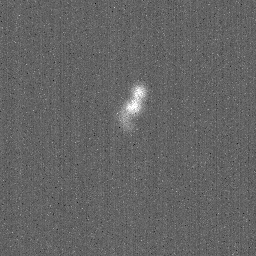

'predicted'

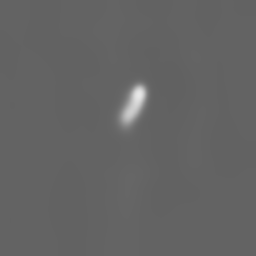

In [ ]:
display('original', transforms.ColorJitter(contrast=[3.0, 3.0])(transforms.CenterCrop((256, 256))(dataset.get_image(9))), 'predicted') # ER 30 kev
display(predict_PIL(model_new, 9))